# Placebo Testing

A placebo test is an approach to assess the validity of a causal model by checking if
the effect can truly be attributed to the treatment, or to other spurious factors. A
placebo test is conducted by iterating through the set of control units and at each
iteration, replacing the treated unit by one of the control units and measuring the
effect. If the model detects a significant effect, then it suggests potential bias or
omitted variables in the analysis, indicating that the causal inference is flawed.

A successful placebo test will show no statistically significant results and we may
then conclude that the estimated effect can be attributed to the treatment and not
driven by confounding factors. Conversely, a failed placebo test, which shows
significant results, suggests that the identified treatment effect may not be
reliable. Placebo testing is thus a critical step to ensure the robustness of findings
in RCTs. In this notebook, we demonstrate how a placebo test can be conducted in
`causal-validation`.

In [3]:
from azcausal.core.error import JackKnife
from azcausal.estimators.panel.did import DID
from azcausal.estimators.panel.sdid import SDID
import numpy as np
from scipy.stats import norm

from causal_validation import (
    Config,
    simulate,
)
from causal_validation.data import DatasetContainer
from causal_validation.effects import StaticEffect
from causal_validation.estimator.utils import AZCausalWrapper
from causal_validation.plotters import plot
from causal_validation.transforms import Trend
from causal_validation.validation.placebo import PlaceboTest
from causal_validation.transforms.parameter import UnitVaryingParameter

## Data simulation

To demonstrate a placebo test, we must first simulate some data. For the purposes of
illustration, we'll simulate a very simple dataset containing 10 control units where
each unit has 60 pre-intervention observations, and 30 post-intervention observations.

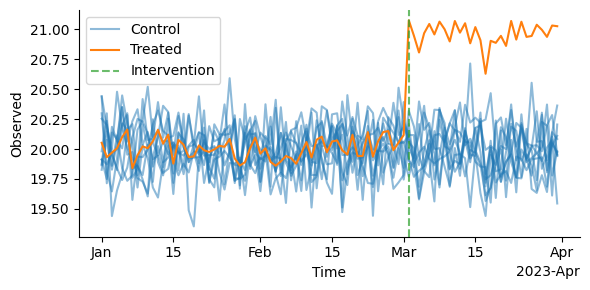

In [4]:
D = np.zeros((90, 11))
D[60:, -1] = 1

cfg = Config(
    treatment_assignments=D,
    seed=123,
)

TRUE_EFFECT = 0.05
effect = StaticEffect(effect=TRUE_EFFECT)
data = effect(simulate(cfg))
ax = plot(data)

## Model

We'll now define our model. To do this, we'll use the synthetic
difference-in-differences implementation of AZCausal. This implementation, along with
any other model from AZCausal, can be neatly wrapped up in our `AZCausalWrapper` to
make fitting and effect estimation simpler.

In [5]:
model = AZCausalWrapper(model=SDID(), error_estimator=JackKnife())

## Placebo Test Results

Now that we have a dataset and model defined, we may conduct our placebo test. With 10
control units, the test will estimate 10 individual effects; 1 per control unit when
it is mocked as the treated group. With those 10 effects, the routine will then
produce the mean estimated effect, along with the standard deviation across the
estimated effect, the effect's standard error, and the p-value that corresponds to the
null-hypothesis test that the effect is 0.

In the below, we see that expected estimated effect is small at just 0.05.
Accordingly, the p-value attains a value of 0.7, indicating that we have insufficient
evidence to reject the null hypothesis and we, therefore, have no evidence to suggest
that there is bias within this particular setup.

In [6]:
result = PlaceboTest(model, datasets=data).execute()
result.summary()

Output()

| Model | Dataset   | Effect | Standard Deviation | Standard Error | p-value |
|-------|-----------|--------|--------------------|----------------|---------|
| SDID  | Dataset 0 | 0.0503 | 0.4101             | 0.1297         | 0.7217  |

## Model Comparison

We can also use the results of a placebo test to compare two or more models. Using
`causal-validation`, this is as simple as supplying a series of models to the placebo
test and comparing their outputs. To demonstrate this, we will compare the previously
used synthetic difference-in-differences model with regular difference-in-differences. In the previous placebo test you'll notice that the dataset in use was named `"Dataset 0"`. We can set the `name` property of our `Dataset` to more cleanly log the name of the data under consideration.

In [7]:
data.name = "Simple"
did_model = AZCausalWrapper(model=DID())
PlaceboTest([model, did_model], data).execute().summary()

Output()

| Model | Dataset | Effect | Standard Deviation | Standard Error | p-value |
|-------|---------|--------|--------------------|----------------|---------|
| SDID  | Simple  | 0.0503 | 0.4101             | 0.1297         | 0.7217  |
| DID   | Simple  | 0.0003 | 0.2873             | 0.0909         | 0.998   |

Sometimes, we may wish to compare multiple models across multiple datasets. Fortunately, this is as simple as providing the datasets as a list to `PlaceboTest`, much like the models we supplied in the previous cell. From here, `causal-validation` will go and conduct a placebo test for each pair of model and dataset. To see this, let us now synthesis a more complex dataset where the intercept and slope of each control unit vary.

In [8]:
cfg2 = Config(
    treatment_assignments=D,
    seed=42,
)


effect = StaticEffect(effect=TRUE_EFFECT)
intercept = UnitVaryingParameter(sampling_dist=norm(0.0, 1.0))
slope = UnitVaryingParameter(sampling_dist=norm(0.2, 0.05))
trend = Trend(degree=1, coefficient=slope, intercept=intercept)
complex_data = effect(trend(simulate(cfg2)))

By default, the data will be named according to the index it was supplied, as seen in previous cells. However, it can be named by wrapping the datasets up in a `DatasetContainer` object and supplying the datasets' names as a list of strings.

In [9]:
datasets = DatasetContainer([data, complex_data], names=["Simple", "Complex"])
PlaceboTest([model, did_model], datasets).execute().summary()

Output()

| Model | Dataset | Effect  | Standard Deviation | Standard Error | p-value |
|-------|---------|---------|--------------------|----------------|---------|
| SDID  | Simple  | 0.0503  | 0.4101             | 0.1297         | 0.7217  |
| DID   | Simple  | 0.0003  | 0.2873             | 0.0909         | 0.998   |
| SDID  | Complex | -0.2304 | 1.3511             | 0.4273         | 0.6213  |
| DID   | Complex | -0.7608 | 9.3481             | 2.9561         | 0.8126  |